# Chapter IV: Improving Training of PINNs

This notebook covers techniques to improve the training of Physics-Informed Neural Networks (PINNs).

In [1]:
import sys
sys.path.append('examples/allen_cahn')
results_folder = 'results/IV_ImprovingTraining'

# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import scienceplots  # optional, requires latex
plt.style.use(['science', 'grid'])
import pickle
import copy

from allen_cahn_model import train_allen_cahn, test_data_allen_cahn, eval_allen_cahn, pde_allen_cahn, plot_allen_cahn_results

Using backend: jax
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



## IV_2: Fourier Feature Embedding

Fourier features help in learning high-frequency components.

### 1-Run/load model

In [2]:
config_to_run_FF = []#["pinn", "spinn", "spinn_mod"]
results_file = os.path.join(results_folder, 'IV_2_FourierFeatures.pkl')

base_config_FF = {
    "fourier_features": False,
    "n_fourier_features": 128,
    "sigma": 10,
    "net_type": "PINN",
    "mlp_type": "mlp",
    "activations": "sin",
    "n_domain": 150**2,
    "learning_rates": [1e-3, 1e-4, 1e-5],
    "n_iters": 20000, 
    "rank": 64,
    "seed": 0,
}

all_config_FF = {
    "pinn": {**copy.deepcopy(base_config_FF), "n_fourier_features": 256},
    "spinn": {**copy.deepcopy(base_config_FF), "net_type": "SPINN" },
    "spinn_mod": {**copy.deepcopy(base_config_FF), "net_type": "SPINN", "mlp_type": "mlp_mod" },
}

all_config_names_FF = list(all_config_FF.keys())

all_data_FF = {}
all_models_FF = {}
try:
    with open(results_file, 'rb') as f:
        saved_results = pickle.load(f)
except Exception:
    saved_results = {}

for config_name in config_to_run_FF:
    print(f"Running configuration: {config_name}")
    config_FF = all_config_FF[config_name]
    
    # Train SPINN with and without Fourier features
    all_data_FF[config_name] = train_allen_cahn(config_FF)
    all_data_FF[config_name + "_FF"] = train_allen_cahn({**config_FF, "fourier_features": True})

    # Extract models
    all_models_FF[config_name] = all_data_FF[config_name].pop('model')
    all_models_FF[config_name + "_FF"] = all_data_FF[config_name + "_FF"].pop('model')

    # Update saved results dict
    saved_results.update({
        config_name: {**all_data_FF[config_name], "model_params": all_models_FF[config_name].net.params},
        config_name + "_FF": {**all_data_FF[config_name + "_FF"], "model_params": all_models_FF[config_name + "_FF"].net.params}
    })

# Save updated results back
with open(results_file, 'wb') as f:
    pickle.dump(saved_results, f)


restore_models = False  # Whether to reconstruct the models from saved params

# Load saved results if not all configs were run
if len(config_to_run_FF) < len(all_config_names_FF):
    try:
        with open(results_file, 'rb') as f:
            saved = pickle.load(f)
    except Exception:
        saved = {}
    
    for config_name in all_config_names_FF:
        if config_name in config_to_run_FF:
            continue
        for suffix in ("", "_FF"):
            key = config_name + suffix
            if key not in saved:
                print(f"Warning: {key} not found in saved results.")
                continue
            print(f"Loading saved results for: {key}")
            data = saved[key]
            all_data_FF[key] = {k: v for k, v in data.items() if k != "model_params"}
            if "model_params" in data:
                all_models_FF[key] = data["model_params"]

            if restore_models and "model_params" in data and "config" in data:
                try:
                    all_models_FF[key] = train_allen_cahn({
                        **data["config"],
                        "learning_rates": [1e-3],
                        "n_iters": 0,
                        "restored_params": data["model_params"],
                    })["model"]
                except Exception:
                    pass

Loading saved results for: pinn
Loading saved results for: pinn_FF
Loading saved results for: spinn
Loading saved results for: spinn_FF
Loading saved results for: spinn_mod
Loading saved results for: spinn_mod_FF


### 2-Plot results

Fig width: 10.5, set it to 3.50 < 6.34 (A4 with margins) in latex to have a printed font size of 6.00 for titles and 5.00 for the axis


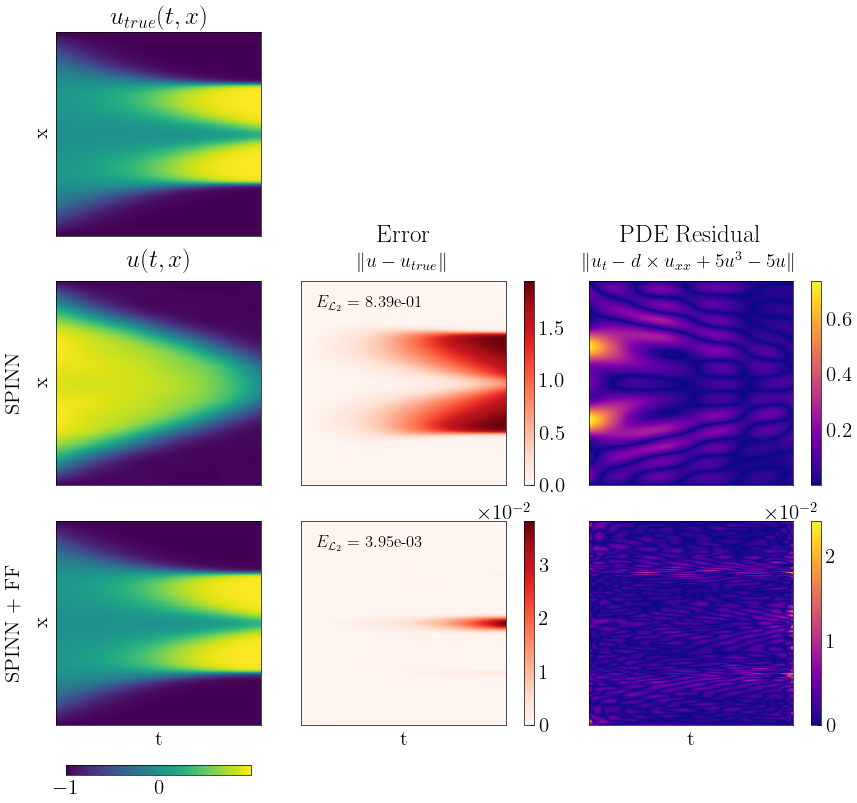

In [7]:
import matplotlib.transforms as mtransforms
from matplotlib import ticker

# --- Font size for printing ---
plotting_factor = 3
font_factor = 3
title_font_size = 6
axes_font_size = 5
plt.rcParams.update({
    "font.size": axes_font_size*font_factor,
    "figure.titlesize": title_font_size*font_factor,
    "axes.titlesize": title_font_size*font_factor,
})


config_to_plot_FF = ["pinn", "spinn", "spinn_mod"][1:2]
config_text_dict = {
    "pinn": "PINN",
    "pinn_FF": "PINN + FF",
    "spinn": "SPINN",
    "spinn_FF": "SPINN + FF",
    "spinn_mod": "SPINN-mod",
    "spinn_mod_FF": "SPINN-mod + FF",
}

X, y, xx, tt, u_true = test_data_allen_cahn(all_config_FF[config_to_plot_FF[0]], dataset_path=os.path.abspath("examples/allen_cahn/dataset/Allen_Cahn.mat"))

u_pred_all, u_diff_all, pde_loss_all, rows_title = [], [], [], []

for base in config_to_plot_FF:
    for key in [base, base + "_FF"]:
        if key not in all_data_FF: 
            continue
        e = all_data_FF[key]["evaluation"]
        u_true = e["u_true"]
        u_pred_all.append(e["u_pred"])
        u_diff_all.append(e["u_pred"] - u_true)
        pde_loss_all.append(e["pde_loss"])
        rows_title.append((e.get("l2_error", 1e9), config_text_dict[key]))

# sort by l2 error
order = sorted(range(len(rows_title)), key=lambda i: rows_title[i][0], reverse=True)
u_pred_all = [u_pred_all[i] for i in order]
u_diff_all = [u_diff_all[i] for i in order]
pde_loss_all = [pde_loss_all[i] for i in order]
rows_title = [rows_title[i][1] for i in order]
n_rows = len(rows_title)

fields_Fourier = {
    "Solution": {
        "data": [u_true] + u_pred_all,
        "title": r"$u(t,x)$",
        "cmap": "viridis",
        "abs": False,
    },
    "Error": {
        "data": u_diff_all,
        "title": "Error\n" + r"\fontsize{14}{14} $\|u - u_{true}\|$",
        "cmap": "Reds",
        "abs": True,
    },
    "PDE Residual": {
        "data": pde_loss_all,
        "title": "PDE Residual\n" + r"\fontsize{14}{14}$\|u_t - d \times u_{xx} + 5u^3 - 5u\|$",
        "cmap": "plasma",
        "abs": True,
    },
}

fig, ax = plt.subplots(1+n_rows,3, figsize=(10.5,(1+n_rows)*3))

plot_allen_cahn_results(fig, ax, fields_Fourier, tt, xx, rows_title, font_factor, title_font_size, axes_font_size)

plt.show()

# save figure
figure_folder = os.path.join(results_folder, "IV_2_FourierFeatures_Figures")
os.makedirs(figure_folder, exist_ok=True)
figure_name = "+".join(config_to_plot_FF) + ".png"
fig.savefig(os.path.join(figure_folder, figure_name), bbox_inches='tight', dpi=300)

In [17]:
import pandas as pd
from IPython.display import display

#table of all results
# build a summary dataframe from all_data_FF
rows = []
append_config = False  # whether to append config parameters to the table
for key in sorted(all_data_FF.keys()):
    entry = all_data_FF[key]
    evaluation = entry.get("evaluation", {})
    l2 = evaluation.get("l2_error", np.nan)
    mean_pde = evaluation.get("mean_pde_residual", np.nan)
    iters_per_s = entry.get("iterations_per_sec", np.nan)
    elapsed = entry.get("elapsed_time", np.nan)
    # use human-readable name if available
    name = config_text_dict.get(key, key) if "config_text_dict" in globals() else key

    rows.append({
        # "model_key": key,
        "model_name": name,
        "l2_error": float(l2) if np.isfinite(l2) else np.nan,
        "mean_pde_residual": float(mean_pde) if np.isfinite(mean_pde) else np.nan,
        "iterations_per_sec": float(iters_per_s) if np.isfinite(iters_per_s) else np.nan,
        "elapsed_time_min": float(elapsed)/60 if np.isfinite(elapsed) else np.nan,
    })
    if append_config:
        config = entry.get("config", {})
        for k, v in config.items():
            if k not in rows[-1]:
                rows[-1][k] = v

df_results = pd.DataFrame(rows)
# sort by l2 error (ascending)
df_results = df_results.sort_values("l2_error", ascending=False).reset_index(drop=True)
# convert elapsed time from seconds to minutes and display

display(
    df_results.style
    .background_gradient(subset=["l2_error"], cmap="Greens_r")
    .format("{:.2e}", subset=["l2_error", "mean_pde_residual"])
    .format("{:.2f}", subset=["iterations_per_sec"])
    .format("{:.2f}", subset=["elapsed_time_min"])
    .set_properties(subset=["model_name"], **{"text-align": "left"})
)

# Save dataframe to latex
latex_folder = os.path.join(results_folder, "IV_2_FourierFeatures_Tables")
os.makedirs(latex_folder, exist_ok=True)
table_name = "one_run_config.tex" if append_config else "one_run.tex"
latex_file = os.path.join(latex_folder, table_name)
with open(latex_file, 'w') as f:
    f.write(df_results.to_latex(index=False, float_format="%.2e", column_format="lcccc", longtable=False))

,model_name,l2_error,mean_pde_residual,iterations_per_sec,elapsed_time_min
0,SPINN,8.39e-01,9.01e-02,623.09,1.60
1,PINN,2.23e-01,3.55e-02,1031.73,0.97
2,SPINN-mod,1.13e-01,1.22e-02,370.86,2.70
3,SPINN + FF,3.95e-03,1.67e-03,542.49,1.84
4,SPINN-mod + FF,9.84e-04,1.26e-03,419.91,2.38
5,PINN + FF,2.39e-04,9.10e-04,261.73,3.82


## IV_3: Adaptive Sampling and Attention

Adaptive sampling resamples points based on residuals. Attention focuses on important features.

In [18]:
RUN_CODE = False  # Set to False to load saved results
results_file = os.path.join(results_folder, 'IV_2_SelfAttention.pkl')
base_config_SA = {
    "fourier_features": True,
    "n_fourier_features": 128,
    "sigma": 10,
    "net_type": "SPINN",
    "mlp_type": "mlp",
    "activations": "sin",
    "n_domain": 150**2,
    "learning_rates": [1e-3, 1e-4, 1e-5],
    "n_iters": 20000,  
    "rank": 64,
    "seed": 0,
    "SA": True,
}


iters_pde_w = [500, 2500, 47000]

if RUN_CODE:
    # Visualize effect of self-attention at the beginning, middle, and end of training
    results_weight_vis = {}
    SA_init = "constant"
    restored_params = None
    data_spinn_weight_vis = train_allen_cahn({**config_spinn_SA, "learning_rates": [1e-3], "n_iters": 0})
    model = data_spinn_weight_vis['model']
    for i, iter in enumerate(iters_pde_w):
        # data_spinn_SA = train_allen_cahn({**config_spinn_SA, "n_iters": iter, "SA_init": SA_init, "restored_params": restored_params})
        loss_history, train_state = model.train(iter)
        results_weight_vis[sum(iters_pde_w[:i+1])] = eval_allen_cahn(config_spinn_SA, model)
        results_weight_vis[sum(iters_pde_w[:i+1])]["pde_weights"] = model.external_trainable_variables[0].value
        print(f"Mean PDE residual after {sum(iters_pde_w[:i+1])} iters: {results_weight_vis[sum(iters_pde_w[:i+1])]['mean_pde_residual']:.3e}")
        print(f"L2 relative error after {sum(iters_pde_w[:i+1])} iters: {results_weight_vis[sum(iters_pde_w[:i+1])]['l2_error']:.3e}")
    
    data_spinn_SA = train_allen_cahn(config_spinn_SA)
    


    with open(results_file, 'wb') as f:
        model_weight_vis = data_spinn_weight_vis.pop('model')
        model_SA = data_spinn_SA.pop('model')
        data_spinn_weight_vis = {**data_spinn_weight_vis, "results": results_weight_vis, "losshistory": loss_history, "model_params": model_weight_vis.net.params}
        data_spinn_SA = {**data_spinn_SA, "model_params": model_SA.net.params}
        pickle.dump({'weight_vis': {**data_spinn_weight_vis},
                     'SA': {**data_spinn_SA}}, f)
else:
    with open(results_file, 'rb') as f:
        saved = pickle.load(f)
        data_spinn_weight_vis = saved['weight_vis']
        data_spinn_SA = saved['SA']
        results_weight_vis = data_spinn_weight_vis["results"]
        results_SA = data_spinn_SA["evaluation"]
        # Reconstruct models
        restore_models = True
        if restore_models:
            model_weight_vis = train_allen_cahn({**data_spinn_weight_vis["config"], "learning_rates": [1e-3], "n_iters": 0, "restored_params": data_spinn_weight_vis["model_params"], "SA_init": results_weight_vis[sum(iters_pde_w)]["pde_weights"]})['model']
            model_SA = train_allen_cahn({**data_spinn_SA["config"], "learning_rates": [1e-3], "n_iters": 0, "restored_params": data_spinn_SA["model_params"], "SA_init": results_SA["pde_weights"]})['model']

Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 3.659707 s

Training model...

Step      Train loss    Test loss     Test metric
0         [6.51e+02]    [6.51e+02]    []  
1000      [1.39e-01]    [1.39e-01]    []  
2000      [4.19e-02]    [4.19e-02]    []  
3000      [2.09e-02]    [2.09e-02]    []  
4000      [6.84e-03]    [6.84e-03]    []  
5000      [3.19e-03]    [3.19e-03]    []  
6000      [1.70e-03]    [1.70e-03]    []  
7000      [9.56e-04]    [9.56e-04]    []  
8000      [1.62e-03]    [1.62e-03]    []  
9000      [2.60e-03]    [2.60e-03]    []  
10000     [1.17e-03]    [1.17e-03]    []  
11000     [3.13e-04]    [3.13e-04]    []  
12000     [9.08e-04]    [9.08e-04]    []  
13000     [1.74e-03]    [1.74e-03]    []  
14000     [7.05e-02]    [7.05e-02]    []  
15000     [2.90e-03]    [2.90e-03]    []  
16000     [2.69e-03]    [2.69e-03]    []  
17000     [1.28e-03]    [1.28e-03]    []  
18000     [7.38e-04]    [7.38e-04]    []  
19000    

In [23]:
results_file = os.path.join(results_folder, 'IV_2_SelfAttention.pkl')

# === Base configuration ===
base_config_SA = {
    "fourier_features": True,
    "n_fourier_features": 128,
    "sigma": 10,
    "net_type": "SPINN",
    "mlp_type": "mlp",
    "activations": "sin",
    "n_domain": 150**2,
    "learning_rates": [1e-3],#, 1e-4, 1e-5],
    "n_iters": 20,
    "rank": 64,
    "seed": 0,
    "SA": True,
}

# === Configs to run ===
config_to_run_SA = []  # e.g. ["pinn", "spinn", "spinn_mod", "weight_vis"]

# === All model configs ===
all_config_SA = {
    "pinn": {**base_config_SA, "net_type": "PINN", "n_fourier_features": 256},
    "spinn": {**base_config_SA, "net_type": "SPINN"},
    "spinn_mod": {**base_config_SA, "net_type": "SPINN", "mlp_type": "mlp_mod"},
    "weight_vis": base_config_SA,
}

all_config_names_SA = list(all_config_SA.keys())


iters_pde_w = [500, 2500, 47000]
all_data_SA, all_models_SA = {}, {}

# === Load existing results ===
try:
    with open(results_file, 'rb') as f:
        saved_results = pickle.load(f)
except Exception:
    saved_results = {}

# === Run or load each configuration ===
for config_name in config_to_run_SA:
    print(f"Running configuration: {config_name}")
    config_SA = all_config_SA[config_name]

    if config_name == "weight_vis":
        results_weight_vis = {}
        data_weight_vis = train_allen_cahn({**config_SA, "learning_rates": [1e-3], "n_iters": 0})
        model = data_weight_vis.pop('model')

        for i, iter_ in enumerate(iters_pde_w):
            loss_history, _ = model.train(iter_)
            total_iter = sum(iters_pde_w[:i+1])
            results_weight_vis[total_iter] = eval_allen_cahn(config_SA, model)
            results_weight_vis[total_iter]["pde_weights"] = model.external_trainable_variables[0].value
            print(f"Iter {total_iter}: L2={results_weight_vis[total_iter]['l2_error']:.3e}, "
                  f"PDE={results_weight_vis[total_iter]['mean_pde_residual']:.3e}")

        all_models_SA[config_name] = model
        all_data_SA[config_name] = {**data_weight_vis, "results": results_weight_vis}

    else:
        data = train_allen_cahn(config_SA)
        all_models_SA[config_name] = data.pop('model')
        all_data_SA[config_name] = data

    saved_results[config_name] = {**data, "model_params": all_models_SA[config_name].net.params}

# Save updated results back
with open(results_file, 'wb') as f:
    pickle.dump(saved_results, f)


restore_models = True  # Whether to reconstruct the models from saved params

# Load saved results if not all configs were run
if len(config_to_run_SA) < len(all_config_names_SA):
    try:
        with open(results_file, 'rb') as f:
            saved = pickle.load(f)
    except Exception:
        saved = {}

    for config_name in all_config_names_SA:
        if config_name in config_to_run_SA:
            continue
        key = config_name
        if key not in saved:
            print(f"Warning: {key} not found in saved results.")
            continue
        print(f"Loading saved results for: {key}")
        data = saved[key]
        all_data_SA[key] = {k: v for k, v in data.items() if k != "model_params"}
        if "model_params" in data:
            all_models_SA[key] = data["model_params"]

        if restore_models and "model_params" in data and "config" in data:
            try:
                all_models_SA[key] = train_allen_cahn({
                    **data["config"],
                    "learning_rates": [1e-3],
                    "n_iters": 0,
                    "restored_params": data["model_params"],
                })["model"]
            except Exception:
                pass


Loading saved results for: spinn
Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.023920 s

Training model...

Step      Train loss    Test loss     Test metric
0         [8.90e-01]    [8.90e-01]    []  

Best model at step 0:
  train loss: 8.90e-01
  test loss: 8.90e-01
  test metric: []

'train' took 2.289476 s

Mean PDE residual: 7.194e-01
L2 relative error: 6.518e-01
Elapsed training time: 2.31 s, 0.00 it/s
Loading saved results for: weight_vis
Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.036235 s

Training model...

Step      Train loss    Test loss     Test metric
0         [1.39e-05]    [1.39e-05]    []  

Best model at step 0:
  train loss: 1.39e-05
  test loss: 1.39e-05
  test metric: []

'train' took 2.014993 s

Mean PDE residual: 2.902e-03
L2 relative error: 3.711e-03
Elapsed training time: 2.05 s, 0.00 it/s


Fig width: 14.5, set it to 4.83 < 6.34 (A4 with margins) in latex to have a printed font size of 6.00 for titles and 5.00 for the axis


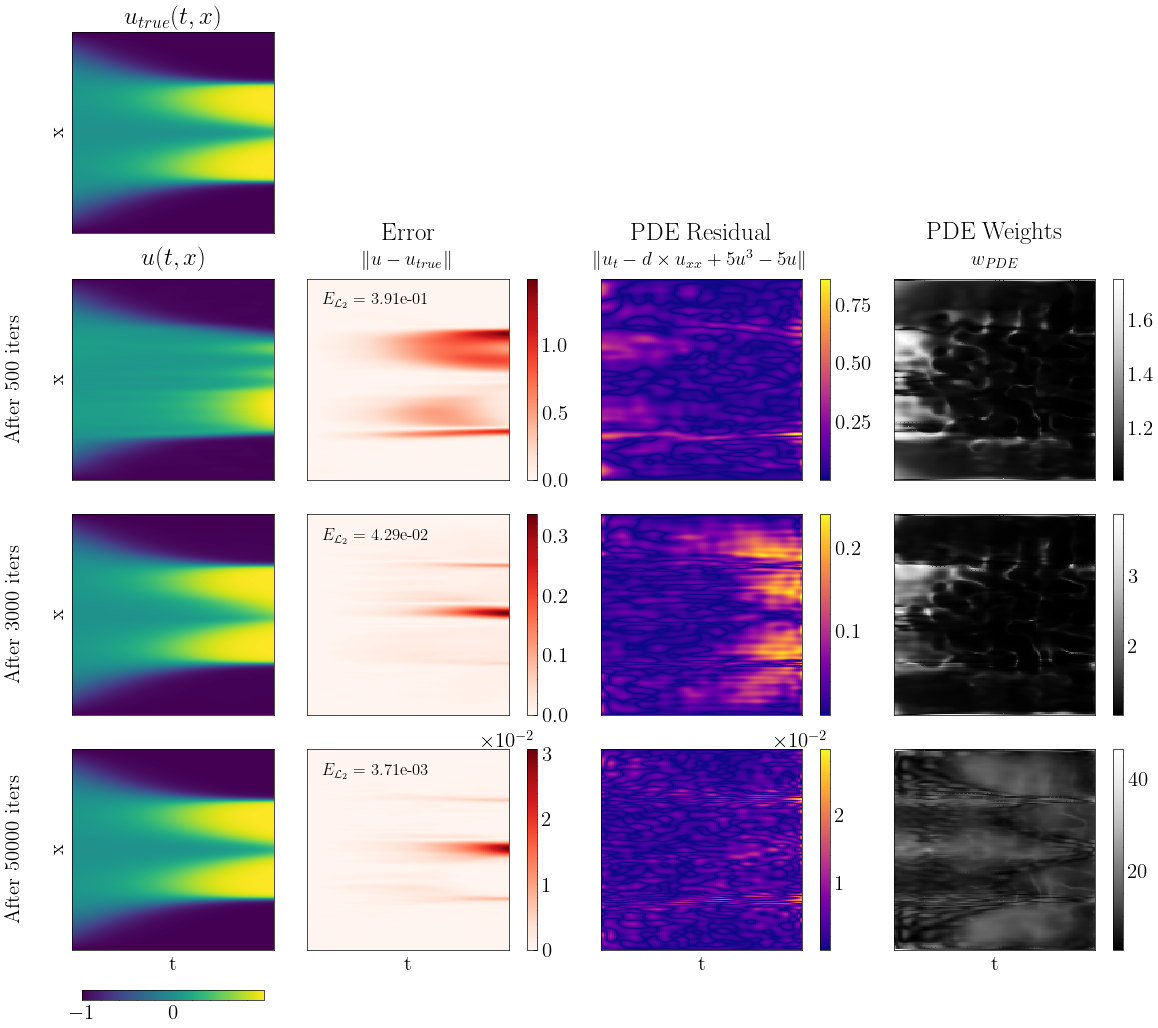

In [26]:
X, y, xx, tt, u_true = test_data_allen_cahn(base_config_SA, dataset_path=os.path.abspath("examples/allen_cahn/dataset/Allen_Cahn.mat"))
X_train = all_models_SA["weight_vis"].data.train_x[0]
x_train, t_train = np.meshgrid(X_train[0], X_train[1])

# Plot evaluation at different PDE weight iterations using results_SA
u_pred_all, pde_loss_all, pde_weights_all = [], [], []
results_weight_vis = all_data_SA["weight_vis"]["results"]
for k in sorted(results_weight_vis.keys()):
    u_pred_all.append(results_weight_vis[k]["u_pred"])
    pde_loss_all.append(results_weight_vis[k]["pde_loss"])
    pde_weights_all.append(results_weight_vis[k]["pde_weights"].reshape(x_train.shape).T)

# Use ground truth from any entry (they are the same)
u_true = results_weight_vis[min(results_weight_vis.keys())]["u_true"]
u_diff_all = [u - u_true for u in u_pred_all]

rows_title = [f"After {k} iters" for k in sorted(results_weight_vis.keys())]

fields_SA_weight_vis = {
    "Solution": {
        "data": [u_true] + u_pred_all,
        "title": r"$u(t,x)$",
        "cmap": None,
        "abs": False,
    },
    "Error": {
        "data": u_diff_all,
        "title": "Error\n" + r"\fontsize{14}{14} $\|u - u_{true}\|$",
        "cmap": "Reds",
        "abs": True,
    },
    "PDE Residual": {
        "data": pde_loss_all,
        "title": "PDE Residual\n" + r"\fontsize{14}{14}$\|u_t - d \times u_{xx} + 5u^3 - 5u\|$",
        "cmap": "plasma",
        "abs": True,
    },
    "PDE Weights": {
        "data": pde_weights_all,
        "title": "PDE Weights\n" + r"\fontsize{14}{14}$w_{PDE}$",
        "cmap": "Greys_r",
        "abs": False,
        "x_fields": x_train,
        "t_fields": t_train,
    },
}
fig, ax = plt.subplots(4,4, figsize=(14.5,12))
plot_allen_cahn_results(fig, ax, fields_SA_weight_vis, tt, xx, rows_title)
plt.show()

Fig width: 10.5, set it to 3.50 < 6.34 (A4 with margins) in latex to have a printed font size of 6.00 for titles and 5.00 for the axis


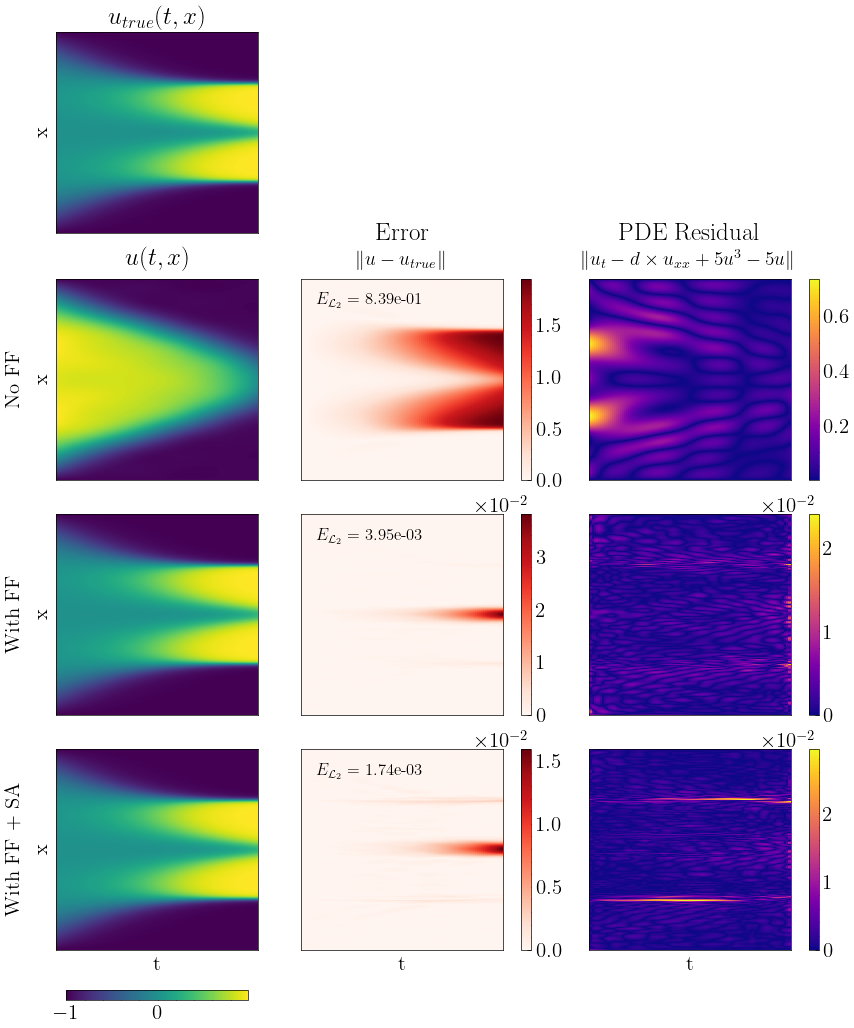

In [19]:
import copy

results_SA = data_spinn_SA["evaluation"]
fields_Fourier_SA = copy.deepcopy(fields_Fourier)
fields_Fourier_SA["Solution"]["data"] +=  [results_SA["u_pred"]]
fields_Fourier_SA["Error"]["data"] += [results_SA["u_pred"] - u_true]
fields_Fourier_SA["PDE Residual"]["data"] += [results_SA["pde_loss"]]

rows_title = ["No FF", "With FF", "With FF + SA"]
fig, ax = plt.subplots(4,3, figsize=(10.5,12))

plot_allen_cahn_results(fig, ax, fields_Fourier_SA, tt, xx, rows_title)